<h1> Initial Plots </h1>

Script to create plots of initial data like float locations and test regions.

In [2]:
import numpy as np
from tqdm import tqdm
#from largescalefunctions import *
import xarray as xr
import scipy.io as sio
import cmocean as cmocean
import glob
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.path as mpath                  # to draw circle for map
import cartopy                                   # to make map
import cartopy.crs as ccrs               # for map projection
import cartopy.feature as cfeature           # to add land features to map
from datetime import date               # for saving figures with today
import matplotlib.animation as animation
from PIL import Image

In [3]:
TS_root = '/global/homes/k/kefalc/code/Test_Data/'
BGC_root = '/global/homes/k/kefalc/code/Test_Data_BGC/'
savepath = '/global/homes/k/kefalc/code/plots/'

In [3]:
#Initializing settings for plots

###### UNIVERSAL PLOT PARAMETERS ######

#### FIGURE SIZE
fig_width  = 3   # inches
fig_height = 3   # inches

#### FONT SIZES
fontsize_large  = 8
fontsize_medium = 6
fontsize_small  = 4

#### MARKER AND LINE SIZES
markersize     = 0.25
axis_linewidth = 1
box_linewidth  = 0.5

#### PLOT COLORS
plot_facecolor          = '#E6F1F1'
overplot_label_color    = '#7B878F'
darker_label_color      = '#C9CCD4'
background_poster_color = '#14417C'
box_color               = '#FA5BBB'

##################################################################
######  Set up Southern Ocean Map  ###############################
##################################################################

def map_southern_ocean_axes_setup(
    ax:                    matplotlib.axes.Axes,
    fig:                   matplotlib.figure.Figure,
    max_latitude:          float = -30,
    add_gridlines:         bool  = True,
    color_land:            bool  = False,
    land_edgecolor:        str   = 'grey',
    land_facecolor:        str   = 'grey',
    fontsize:              float = 10,
    map_facecolor:         str   = 'white',
    coast_linewidth:       float = 0.3,
    gridlines_linewidth:   float = 0.5,
    girdlines_color:       str   = 'grey',
    gridlines_alpha:       float = 0.5,
    longitude_label_color: str   = 'grey',
    latitude_label_color:  str   = 'grey'
) -> None:
    """
    This function sets up the subplot so that it is a cartopy map of the Southern Ocean.
    returns void as the ax and figure objects are pointers not data.
    Args:
        ax  (matplotlib.axes.Axes):     The axis object to add the map to.
        fig (matplotlib.figure.Figure): The figure object for the figure in general.
        add_gridlines (bool):           Whether or not to add gridlines to the plot.
    """
    
    
    ### Limit the map to -40 degrees latitude and below.
    ax.set_extent([-180, 180, -90, max_latitude+0.6], ccrs.PlateCarree())  # set to -29.4 for map out to 30 degrees or -39.4 for map out to 40 degrees
   
    ### Tune the subplot layout
    fig.subplots_adjust(bottom=0.05, top=0.95, left=0.04, right=0.95, wspace=0.02)
    
    ### Make the background of the plot white
    ax.set_facecolor(map_facecolor)

    ### Make SO plot boundary a circle
    def plot_circle_boundary() -> None:
        """
        Make SO plot boundary a circle.
        Compute a circle in axes coordinates, which we can use as a boundary for the map.
        We can pan/zoom as much as we like - the boundary will be permanently circular.
        """
        theta  = np.linspace(0, 2 * np.pi, 100)
        center, radius = [0.5, 0.5], 0.5  ## could use 0.45 here, as Simon Thomas did
        verts  = np.vstack([np.sin(theta), np.cos(theta)]).T
        circle = mpath.Path(verts * radius + center)
        ax.set_boundary(circle, transform = ax.transAxes)

    plot_circle_boundary()


    ### Add gridlines (if True)
    if add_gridlines:
        ax.gridlines(color = girdlines_color, alpha = gridlines_alpha, linewidth = gridlines_linewidth)
        
                # specifying xlocs/ylocs yields number of meridian/parallel lines
        dmeridian = 60  # spacing for lines of meridian
        dparallel = 20  # spacing for lines of parallel -- can change this to 10
        num_merid = int(360/dmeridian + 1)
        num_parra = int(180/dparallel + 1)
        gl = ax.gridlines(crs=ccrs.PlateCarree(), 
                          xlocs=np.linspace(-180, 180, num_merid), 
                          ylocs=np.linspace(-90, 90, num_parra), 
                          linestyle="-", linewidth=0.5, color='grey', alpha=gridlines_alpha)
        
        # for label alignment
        va = 'center' # also bottom, top
        ha = 'center' # right, left
        degree_symbol = u'\u00B0'

        # for locations of (meridional/longitude) labels
        lond = np.linspace(-180, 180, num_merid)
        latd = np.zeros(len(lond))

        for (alon, alat) in zip(lond, latd):
            projx1, projy1 = ax.projection.transform_point(alon, max_latitude+1, ccrs.Geodetic())  # set to -29 for map out to 30 degrees or -39 for a map out to 40 degrees
            if alon>-180 and alon<0:
                ha = 'right'
                va = 'center'
            if alon>0 and alon<180:
                ha = 'left'
                va = 'center'
            if np.abs(alon-0)<0.01:
                ha = 'center'
                va = 'bottom'
            if alon==-180:
                ha = 'center'
                va = 'top'
            if (alon<180):
                txt =  ' {0} '.format(str(int(alon)))+degree_symbol
                ax.text(projx1, projy1, txt, va=va, ha=ha, color=latitude_label_color, fontsize=fontsize)
                
        # for locations of (meridional/longitude) labels select longitude: 315 for label positioning
        lond2 = 60*np.ones(len(lond))
        latd2 = np.linspace(-90, 90, num_parra)
        va, ha = 'center', 'center'
        for (alon, alat) in zip(lond2, latd2):
            projx1, projy1 = ax.projection.transform_point(alon, alat, ccrs.Geodetic())
            txt =  ' {0} '.format(str(int(alat)))+degree_symbol
            ax.text(projx1, projy1, txt, va=va, ha=ha, color=longitude_label_color, fontsize=fontsize) 
        
        
    ### Add in coastlines/features
    if color_land:
        ax.add_feature(cfeature.LAND, zorder=0, linewidth = coast_linewidth, edgecolor=land_edgecolor, facecolor=land_facecolor)
    else:
        ax.coastlines(resolution = "50m", linewidth = coast_linewidth)

In [45]:
##Open Datasets
bgc = xr.open_dataset('/global/homes/k/kefalc/code/data_files/ARGO/SO_BGC.nc')
ts = xr.open_dataset('/global/homes/k/kefalc/code/data_files/floats_years_2015_2017_temperature_salinity_10daily_SO_Test_edit.nc')
display(bgc)

<xarray.Dataset>
Dimensions:           (pressure: 29, profile: 2878)
Coordinates:
    lon               (profile) float64 ...
    lat               (profile) float64 ...
    time              (profile) float64 ...
  * profile           (profile) float64 0.0 1.0 2.0 ... 1.105e+04 1.105e+04
    WMOID             (profile) float64 ...
  * pressure          (pressure) int64 5 10 20 30 50 ... 1700 1800 1900 2000
Data variables:
    temperature       (pressure, profile) float64 ...
    salinity          (pressure, profile) float64 ...
    dissolved_oxygen  (pressure, profile) float64 ...

In [49]:
ul = np.unique(ts.temperature)
ul.size

22208

<h2> Float Locations </h2>

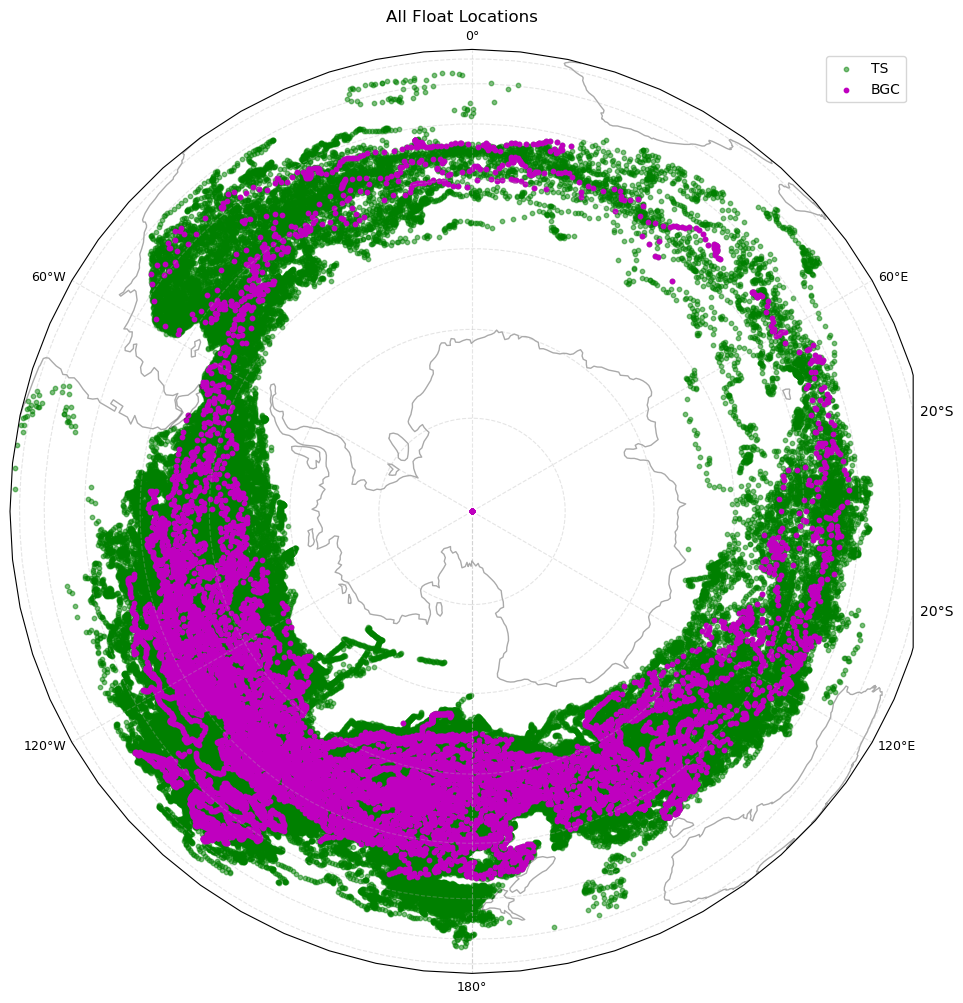

In [4]:
#plot locations of BGC and TS only float profiles on a map projection

plt.figure(figsize=(16,12))

projection = ccrs.NearsidePerspective(central_latitude=-90)
data_crs = ccrs.PlateCarree()

ax = plt.axes(projection=projection)
#ax.stock_img()
ax.coastlines(alpha=0.3333)
gl = ax.gridlines(draw_labels=True,alpha=0.33, linestyle='--')
#ax.set_extent([-140,-130,-90, -30])
gl.xlabel_style = {'size': 9}

#TS files
file_list = glob.glob(TS_root + '*_prof.nc')
for filename in file_list:
    ds = xr.open_dataset(filename)
    ds = ds.rename({'CYCLE_NUMBER':'PROF_NUM'}).swap_dims({'N_PROF':'PROF_NUM'})
    plt.scatter(ds.LONGITUDE,ds.LATITUDE,c='g',s=10,alpha=0.5, transform=data_crs);
plt.scatter(ds.LONGITUDE,ds.LATITUDE,c='g',s=10,alpha=0.5,label='TS');#line needed to create legend

#BGC files
file_list=glob.glob(BGC_root + '*_Sprof.nc')
for filename in file_list:
    ds = xr.open_dataset(filename)
    ds = ds.rename({'CYCLE_NUMBER':'PROF_NUM'}).swap_dims({'N_PROF':'PROF_NUM'})
    plt.scatter(ds.LONGITUDE,ds.LATITUDE,c='m',s=10, transform=data_crs);
plt.scatter(ds.LONGITUDE,ds.LATITUDE,c='m',s=10,label='BGC'); #line needed to create legend
    
plt.title("All Float Locations")
plt.legend(loc='upper right')

#save figure
#plt.savefig(savepath + 'BGC_TS_Locations_all_SO.png')

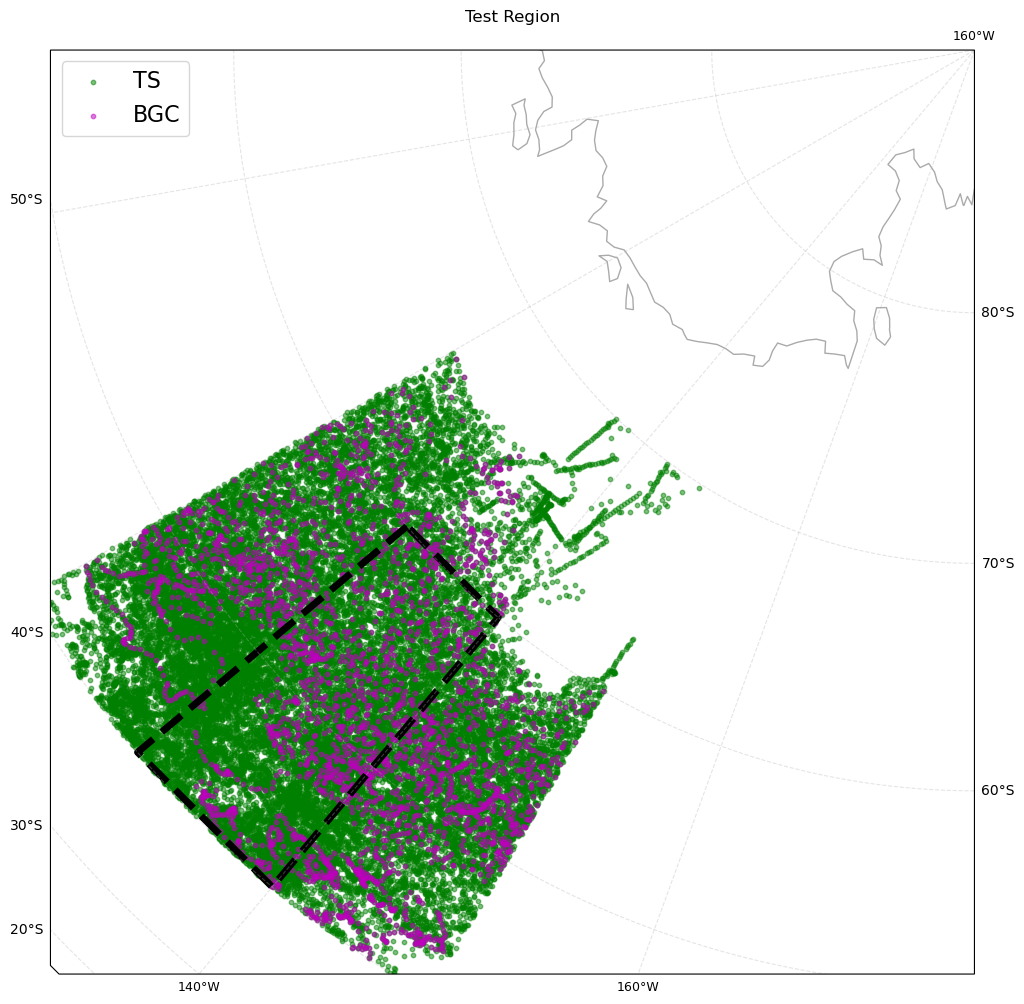

In [6]:
#Float locations within the test region on a map projection

plt.figure(figsize=(16,12))

projection = ccrs.NearsidePerspective(central_latitude=-90)
data_crs = ccrs.PlateCarree()

ax = plt.axes(projection=projection)
#ax.stock_img()
ax.coastlines(alpha=0.3333)
gl = ax.gridlines(draw_labels=True,alpha=0.33, linestyle='--')
ax.set_extent([-140,-130,-90, -30])
gl.xlabel_style = {'size': 9}

#TS
loc = plt.scatter(ts.lon,ts.lat, c='g',s=10,alpha=0.5, transform=data_crs, label='TS')
plt.title('Test Region')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

#BGC
loc = plt.scatter(bgc.lon,bgc.lat, c='m',s=10,alpha=0.5, transform=data_crs, label='BGC')


#Add box
# Corners of boxes:
min_lon = -130
max_lon = -140
min_lat = -60
max_lat = -40
# Add boxes around zoomed-in sections:
lon_corners = np.array([min_lon, min_lon, max_lon, max_lon, min_lon])
lat_corners = np.array([min_lat, max_lat, max_lat, min_lat, min_lat])
box_corners = np.zeros((len(lat_corners), 2), np.float64)
box_corners[:,0] = lon_corners
box_corners[:,1] = lat_corners
# Add box
ax.plot(lon_corners, lat_corners, linestyle='--', linewidth=5, c='k', transform=data_crs)


plt.legend(fontsize=16, loc='upper left')

Text(0, 0.5, 'Latitude')

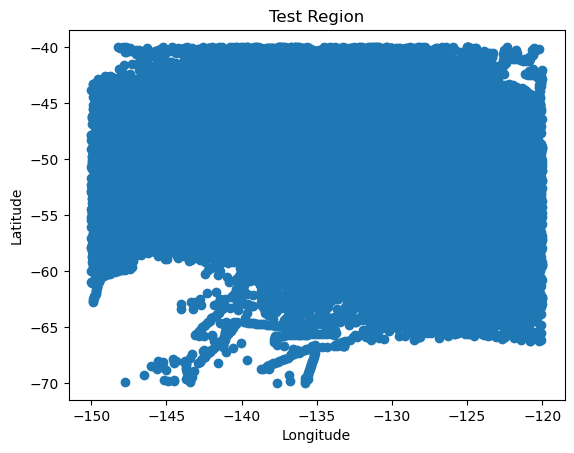

In [8]:
#TS float locations in the test region
loc = plt.scatter(ts.lon,ts.lat)
plt.title('Test Region')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
#plt.savefig(savepath + 'test_floats.png')

<h2> Test Region on Map </h2>

<Figure size 640x480 with 0 Axes>

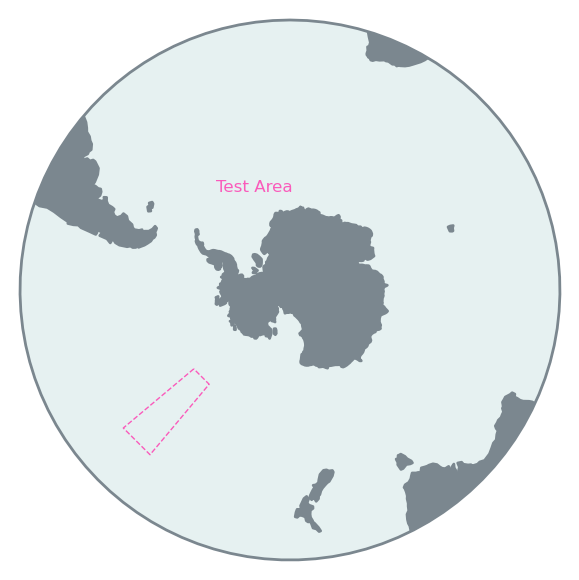

In [9]:
#map with highlighted area
#Use to highlight the area being looked at

##############################
########## Set up ############
##############################

###### SAVE NAME ######
savedate = date.today().strftime('%Y%m%d')

plt.rcParams["axes.edgecolor"] = overplot_label_color
plt.rcParams["axes.linewidth"] = axis_linewidth
plt.figure(facecolor='none') 

###### SET UP PLOT ######
map_proj = ccrs.SouthPolarStereo()

fig  = plt.figure(figsize=[fig_width, fig_height], dpi=200) # inches
ax1  = plt.subplot(projection = map_proj)



##############################################################################
#########################   MAP WITHOUT DATA   ###############################
##############################################################################

###### SET UP MAP ######
# Set up plot axes
map_southern_ocean_axes_setup(ax1, fig, add_gridlines = False, color_land = True,
                              land_facecolor = overplot_label_color,
                              land_edgecolor = overplot_label_color,
                              fontsize = fontsize_large,
                              map_facecolor = plot_facecolor, #'#d7dce8',
                              coast_linewidth = 1,
                              gridlines_linewidth  = 4,
                              girdlines_color = 'grey',
                              gridlines_alpha = 0.1,
                              longitude_label_color = darker_label_color,
                              latitude_label_color  = overplot_label_color)
# note that currently, latitude labels extend too far -- can't figure out how to cut them off outside of the plot



###### ADD BOX AROUND REGIONS OF INTEREST

# Corners of boxes:
min_lon = -130
max_lon = -140
min_lat = -60
max_lat = -40

# Add boxes around zoomed-in sections:
lon_corners = np.array([min_lon, min_lon, max_lon, max_lon, min_lon])
lat_corners = np.array([min_lat, max_lat, max_lat, min_lat, min_lat])
box_corners = np.zeros((len(lat_corners), 2), np.float64)
box_corners[:,0] = lon_corners
box_corners[:,1] = lat_corners

# Add box
ax1.plot(lon_corners, lat_corners, linestyle='--', linewidth=box_linewidth, c=box_color, transform=ccrs.Geodetic())

# # Label box
ax1.annotate('Test Area', xy=(-20,-65), color=box_color, size = fontsize_medium, xycoords=ccrs.PlateCarree()._as_mpl_transform(ax1), horizontalalignment='center')



###### SAVE PLOT ######
plt.savefig(savepath + savename + '_' + savedate + '.png', format='png', bbox_inches='tight')
plt.savefig(savepath + savename                  + '.png', format='png', bbox_inches='tight')
plt.show()

<h3>Synthetic Floats</h3>

In [35]:
ds = xr.open_dataset('/global/homes/k/kefalc/code/data_files/floats_years_2015_2017_temperature_salinity_10daily_SO_Test.nc')
ds

<xarray.Dataset>
Dimensions:      (pressure: 8, profile: 3564)
Coordinates:
    lat          (profile) float64 ...
    lon          (profile) float64 ...
  * pressure     (pressure) float64 -5.0 -10.0 -100.0 ... -1e+03 -1.5e+03 -3e+03
    time         (profile) float64 ...
Dimensions without coordinates: profile
Data variables:
    temperature  (pressure, profile) float64 ...
    salinity     (pressure, profile) float64 ...
Attributes:
    contact:      Kristen Falcinelli, kefalc@uw.edu
    source_file:  /global/cfs/cdirs/m4003/maltrud/southernOceanRefined/profil...
    script:       /global/homes/k/kefalc/code/gpr-mapping-data/save_floats_E3...

In [38]:
ds.time.values

array([1.4832720e+18, 1.4832720e+18, 1.4832720e+18, ..., 1.4515632e+18,
       1.4515632e+18, 1.4515632e+18])

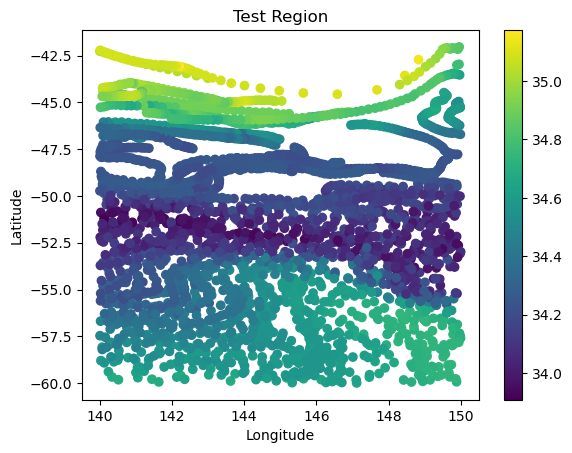

In [34]:
loc = plt.scatter(ds.lon,ds.lat, c = ds.salinity[3,:])
plt.title('Test Region')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
cbar = plt.colorbar(loc)
# plt.xlim(40,50)
# plt.ylim(-60,-40)